## 1. Augmentation을 적용한 데이터셋 만들기

In [15]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds


In [16]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [17]:
def onehot(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    onehot_imgs = []
    onehot_labels = []
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        if len(label_a.shape)==0:
            label_a = tf.one_hot(label_a, num_classes)
        onehot_imgs.append(image_a)
        onehot_labels.append(label_a)
    onehot_imgs = tf.reshape(tf.stack(onehot_imgs),(batch_size, img_size, img_size, 3))
    onehot_labels = tf.reshape(tf.stack(onehot_labels),(batch_size, num_classes))
    return onehot_imgs, onehot_labels

In [18]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, 
                               with_img=False, with_aug=False, 
                               with_cutmix=False, with_mixup=False,
                               one_hot=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    if not is_test and with_mixup:
        ds = ds.map(
            mixup, 
            num_parallel_calls=2
        )
    if is_test and one_hot:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## 2. 모델 만들기

In [19]:
def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00)) # 50%의 확률로 이미지 가운데 부분을 crop합니다.
    image = tf.image.resize(image, INPUT_SHAPE) # crop한 이미지를 원본 사이즈로 resize
    return image, label

In [20]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [21]:
#Augmentation을 적용한 데이터셋으로 학습시킬 ResNet을 하나 더 만들어줍니다.

aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [22]:
'''
텐서플로우 데이터셋에서 불러온 데이터에 
하나는 apply_normalize_on_dataset()에서 with_aug를 False로 하여 augmentation이 적용되지 않도록 하고, 
다른 하나는 True로 주어 augmentation이 적용되도록 합니다.
'''
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

## 3. 모델 훈련하기

In [23]:
tf.random.set_seed(2020)
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
  2/750 [..............................] - ETA: 54s - loss: 5.3739 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0539s vs `on_train_batch_end` time: 0.0921s). Check your callbacks.


750/750 [==============================] - 134s 179ms/step - loss: 2.2008 - accuracy: 0.4523 - val_loss: 3.5807 - val_accuracy: 0.1693
Epoch 2/20
750/750 [==============================] - 109s 146ms/step - loss: 0.7606 - accuracy: 0.7893 - val_loss: 1.1263 - val_accuracy: 0.6679
Epoch 3/20
750/750 [==============================] - 110s 146ms/step - loss: 0.3101 - accuracy: 0.9283 - val_loss: 1.0182 - val_accuracy: 0.6988
Epoch 4/20
750/750 [==============================] - 110s 146ms/step - loss: 0.1093 - accuracy: 0.9864 - val_loss: 0.9243 - val_accuracy: 0.7317
Epoch 5/20
750/750 [==============================] - 119s 159ms/step - loss: 0.0482 - accuracy: 0.9954 - val_loss: 0.9308 - val_accuracy: 0.7404
Epoch 6/20
750/750 [==============================] - 112s 150ms/step - loss: 0.0337 - accuracy: 0.9970 - val_loss: 0.9282 - val_accuracy: 0.7409
Epoch 7/20
750/750 [==============================] - 113s 151ms/step - loss: 0.0201 - accuracy: 0.9984 - val_loss: 0.9483 - val_accura

750/750 [==============================] - 110s 147ms/step - loss: 2.2223 - accuracy: 0.4368 - val_loss: 2.6158 - val_accuracy: 0.3330
Epoch 2/20
750/750 [==============================] - 110s 147ms/step - loss: 0.9546 - accuracy: 0.7229 - val_loss: 1.1976 - val_accuracy: 0.6558
Epoch 3/20
750/750 [==============================] - 110s 147ms/step - loss: 0.5503 - accuracy: 0.8392 - val_loss: 1.2372 - val_accuracy: 0.6556
Epoch 4/20
750/750 [==============================] - 110s 147ms/step - loss: 0.3273 - accuracy: 0.9138 - val_loss: 1.0671 - val_accuracy: 0.6944
Epoch 5/20
750/750 [==============================] - 110s 147ms/step - loss: 0.1947 - accuracy: 0.9568 - val_loss: 0.9948 - val_accuracy: 0.7161
Epoch 6/20
750/750 [==============================] - 110s 147ms/step - loss: 0.1194 - accuracy: 0.9761 - val_loss: 1.0480 - val_accuracy: 0.7069
Epoch 7/20
750/750 [==============================] - 110s 147ms/step - loss: 0.0676 - accuracy: 0.9902 - val_loss: 1.0169 - val_accura

## 4. 훈련 과정 시각화하기

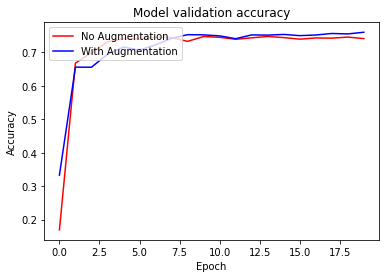

In [24]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

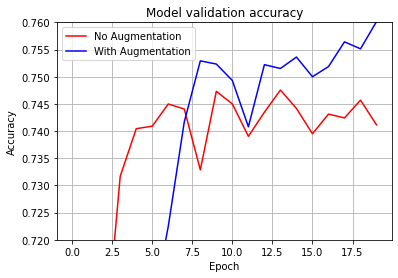

In [25]:
#확대해서 살펴보기
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)
plt.show()

## 5. Augmentation 에 의한 모델 성능 비교

### Cutmix Augmentation

In [26]:
ds_test_no = apply_normalize_on_dataset(ds_test, is_test = True)
ds_test_one = apply_normalize_on_dataset(ds_test, one_hot=True, is_test = True)

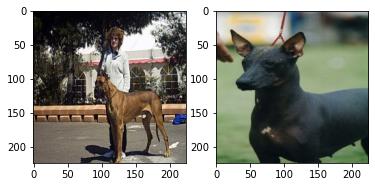

In [27]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

In [28]:
# 바탕 이미지 a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수를 먼저 구현해 봅시다.

def get_clip_box(image_a, image_b, img_size=224):
    # get center of box
    x = tf.cast( tf.random.uniform([],0, img_size),tf.int32)
    y = tf.cast( tf.random.uniform([],0, img_size),tf.int32)

    # get width of box
    _prob = tf.random.uniform([],0,1)
    width = tf.cast(img_size * tf.math.sqrt(1-_prob),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(65, shape=(), dtype=int32) tf.Tensor(61, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


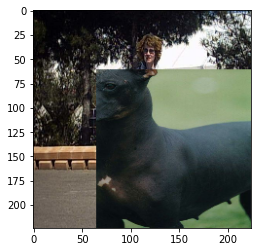

In [29]:
#바탕이미지 a에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=224):
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:img_size,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

In [30]:
#위에서 섞인 이미지 두 가지에 대하여 라벨을 만들 때 적절한 비율로 라벨을 합쳐주는 함수
# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    mixed_area = (xb-xa)*(yb-ya)
    total_area = img_size*img_size
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [31]:

def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_label

### Mixup Augmentation

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.48347813
 0.         0.         0.         0. 

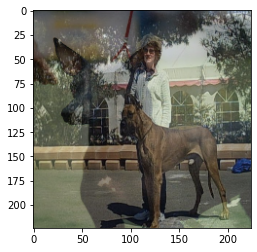

In [32]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

mixed_img, _ = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

In [33]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels